In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# from __future__ import division
from import_file import *
from helpers.parallel_helper import *
load_libs()

In [2]:
# Import data file
file_path= "./data/NCDC/europe/ciampino/dat.txt"
df = pd.read_csv(file_path,header=0, skipinitialspace=True)
df.drop(['USAF', 'NCDC', 'I','QCP','Q','Q.1','I.1','Unnamed: 12'], 1,inplace=True)
df.rename(columns={'Date':'date','Dir': 'dir', 'Spd':'speed'}, inplace=True)
df.describe()

,date,HrMn,dir,speed
count,8.569480e+05,856948.000000,856948.000000,856948.000000
mean,1.990803e+07,1171.849007,339.471443,2.954437
std,1.508621e+05,691.188940,353.528048,17.612657
min,1.951100e+07,0.000000,1.000000,0.000000
25%,1.981071e+07,600.000000,110.000000,1.000000
50%,1.990033e+07,1200.000000,200.000000,2.100000
75%,2.004092e+07,1800.000000,340.000000,4.100000
max,2.015090e+07,2359.000000,999.000000,999.900000


# 1. Simple Data Handling

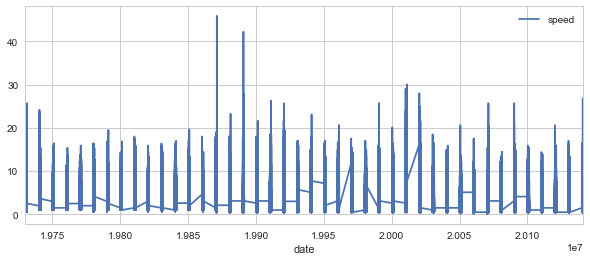

In [3]:
# Select year 1945-2014, dir < 999, speed<999
df = df[(df['dir'] < 999) & (df['speed'] < 999)& (df['date'] > 19720000) &(df['date'] < 20150000) ]
df.rename(columns={'speed':'speed_mps'}, inplace=True)
df['speed']=df['speed_mps']
df.index= df['date']
df['speed'].plot(legend=True,figsize=(10,4), grid=True)

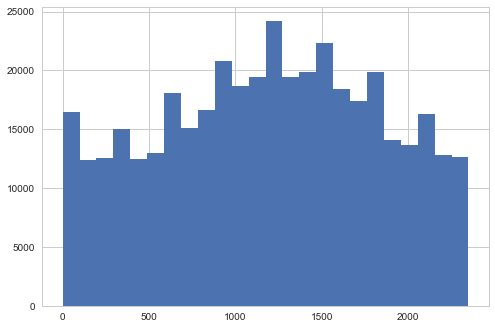

In [4]:
# Check time sample distribution
# found that its not equally sampled.
time = df[df['HrMn'] % 10 <= 0.1]
time['HrMn'].hist(bins = 24)

9.0    148744
0.0     93391
7.0       370
8.0       353
6.0       285
1.0       201
4.0       179
3.0       113
5.0       106
2.0        76
Name: speed_remain, dtype: int64
9.0    210033
0.0    103192
8.0     64328
1.0      1784
Name: speed_remain, dtype: int64


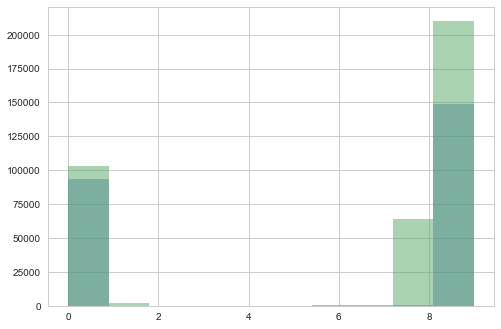

In [5]:
df['artifact'] = False

# Simple artifact detection
# 1. dir error
df.ix[df['dir'] % 10 >=0.1,'artifact']=True

# 2. Speed remain error
# Generate the first digit of fractional part of the speed(after convert to knot unit)
# e.g. 48.5 -> 5
import math
df['speed']=df['speed_mps']*1.943845
df['speed_remain'] = df['speed'].apply(lambda x: math.modf(x*10 % 10)[1])

# Plot the distribution of speed_remain,
# and compare between year<2000 and > 2000
temp = df[(df['date'] > 20000000)]
temp['speed_remain'].hist(bins = 10,alpha=0.5)
print(temp['speed_remain'].value_counts())

temp = df[(df['date'] < 20000000)]
temp['speed_remain'].hist(bins = 10,alpha=0.5)
print(temp['speed_remain'].value_counts())

In [6]:
# From the distribution above, 
# we can know that the legit number are only 0 and 9, all others are too rare to be normal.
df.ix[(df['speed_remain'] >= 2)&(df['speed_remain'] <= 7),'artifact']=True
df.drop(['speed_remain'], 1,inplace=True)
# and then converted the speed into integer
df.rename(columns={'speed':'speed_flt'}, inplace=True)
df[df['artifact']== True].head(20)

,date,HrMn,Type,dir,speed_mps,speed_flt,artifact
date,,,,,,,
19920630,19920630,410,FM-15,7,2.0,3.887690,True
19920911,19920911,1000,FM-15,48,1.5,2.915768,True
19920921,19920921,520,FM-15,88,0.5,0.971923,True
19920923,19920923,220,FM-15,48,1.0,1.943845,True
19921009,19921009,650,FM-15,205,1.5,2.915768,True
19921018,19921018,210,FM-16,225,5.1,9.913609,True
19921218,19921218,1910,FM-15,119,1.5,2.915768,True
19921219,19921219,420,FM-15,202,2.5,4.859612,True
19930201,19930201,1310,FM-15,338,1.5,2.915768,True


In [7]:
df.describe()

,date,HrMn,dir,speed_mps,speed_flt
count,6.231550e+05,623155.000000,623155.000000,623155.000000,623155.000000
mean,1.994993e+07,1192.283676,161.537656,3.300146,6.414971
std,1.177177e+05,655.681125,97.407383,2.329096,4.527402
min,1.973010e+07,0.000000,1.000000,0.100000,0.194385
25%,1.987013e+07,650.000000,70.000000,1.500000,2.915768
50%,1.992123e+07,1215.000000,170.000000,2.600000,5.053997
75%,2.006062e+07,1720.000000,230.000000,4.100000,7.969764
max,2.014123e+07,2355.000000,360.000000,45.800000,89.028101


In [8]:
df['speed'] =  df['speed_flt'].apply(lambda x: int(round(x)))

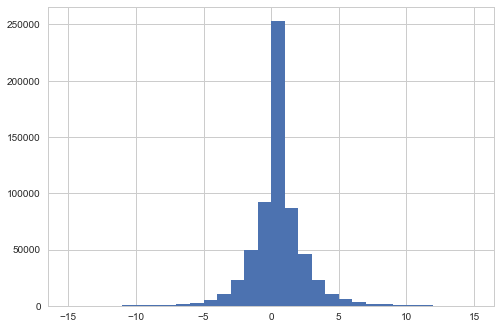

In [9]:
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0)
df['incre'].hist(bins=arange(-15, 15 + 1))

In [10]:
# Sudden increase from nearby data, consider singular increase
artifact = df[((df['incre'] > 20)&(df['incre_reverse'] > 20))]
df.ix[((df['incre'] > 20)&(df['incre_reverse'] > 20)),'artifact']=True
print(len(artifact))
artifact

46


,date,HrMn,Type,dir,speed_mps,speed_flt,artifact,speed,incre,incre_reverse
date,,,,,,,,,,
19731226,19731226,918,FM-16,160,15.4,29.935213,False,30,25.0,26.0
19881213,19881213,1800,FM-15,50,23.2,45.097204,False,45,42.0,41.0
19891114,19891114,750,FM-15,30,27.8,54.038891,False,54,48.0,50.0
19891124,19891124,520,FM-15,10,15.4,29.935213,False,30,25.0,28.0
19911109,19911109,510,FM-15,180,26.3,51.123124,False,51,40.0,41.0
19920530,19920530,210,FM-15,150,25.7,49.956817,False,50,40.0,46.0
19920714,19920714,310,FM-15,30,18.0,34.989210,False,35,32.0,31.0
19921204,19921204,320,FM-15,230,19.5,37.904978,False,38,28.0,31.0
19930421,19930421,900,FM-15,240,15.9,30.907136,False,31,28.0,30.0


In [11]:
artifact = df[(df['artifact']==True)&(df['Type']=='FM-15')]
print(len(artifact))
df = df[(df['artifact']==False)]

153


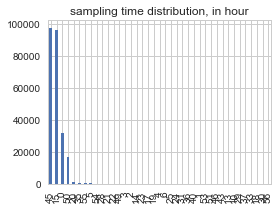

In [12]:
df['sample_time'] = df.HrMn % 100 
sample_time = df.query('date > 20000000')['sample_time']
sample_time.value_counts().plot(
    kind = 'bar', title = 'sampling time distribution, in hour', figsize=(4,3))

In [13]:
# # # Need more elaboration
# sample_times = sample_time.value_counts()[sample_time.value_counts() > 2000]
# sample_times = sample_times.index.tolist()
# df = df.query("sample_time in @sample_times")
# df.drop(['sample_time'], 1,inplace=True)

In [14]:
# Sort by max
df = df.query('date > 20000000')
df.sort('speed',ascending=False)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,date,HrMn,Type,dir,speed_mps,speed_flt,artifact,speed,incre,incre_reverse,sample_time
date,,,,,,,,,,,
20090220,20090220,1145,FM-15,360,25.7,49.956817,False,50,42.0,0.0,45
20090220,20090220,1200,FM-12,360,25.7,49.956817,False,50,0.0,42.0,0
20021116,20021116,745,FM-15,140,21.6,41.987052,False,42,2.0,5.0,45
20011227,20011227,1800,FM-12,340,21.0,40.820745,False,41,20.0,23.0,0
20020523,20020523,1800,FM-12,170,21.0,40.820745,False,41,20.0,27.0,0
20010313,20010313,600,FM-12,160,21.0,40.820745,False,41,20.0,22.0,0
20010304,20010304,0,FM-12,160,21.0,40.820745,False,41,20.0,26.0,0
20021116,20021116,615,FM-16,140,21.1,41.015130,False,41,5.0,7.0,15
20020206,20020206,1200,FM-12,160,21.0,40.820745,False,41,20.0,22.0,0


# 2. Basic Data Info

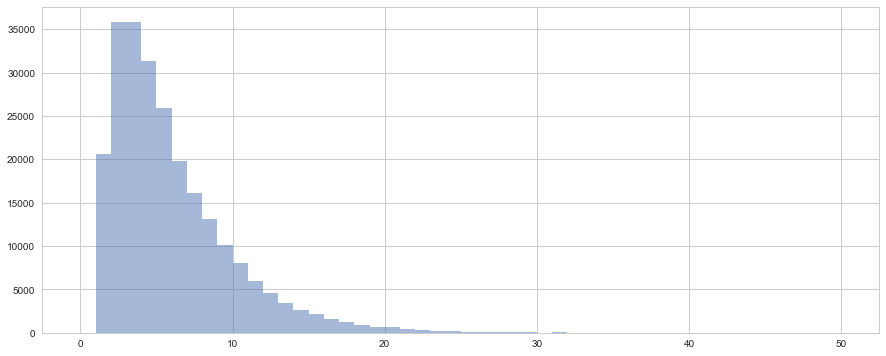

In [15]:
# Speed seems only have integers
# bins=np.arange(min(df.speed_mps), max(df.speed_mps) + 0.5, 0.5)
# df['speed_mps'].hist(bins=bins,figsize=(15, 6))
bins=np.arange(min(df.speed), max(df.speed) + 1, 1)
df['speed'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

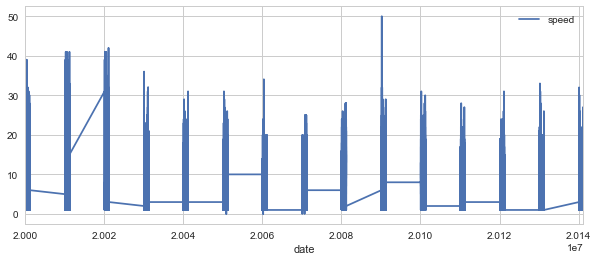

In [16]:
df['speed'].plot(legend=True,figsize=(10,4), grid=True)

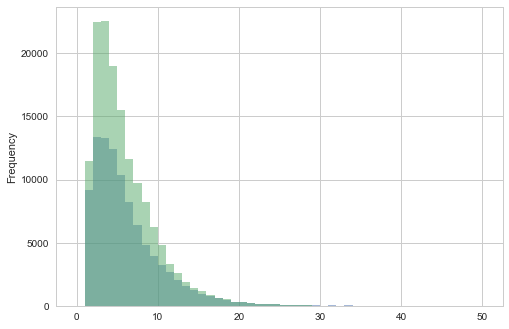

In [17]:
# has severe problem in odd-even bias
# and the overal trend seems moved
MID_YEAR = (min(df.date)//10000+max(df.date)//10000)//2

bins = arange(0, max(df.speed) + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='> %s' % MID_YEAR)

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


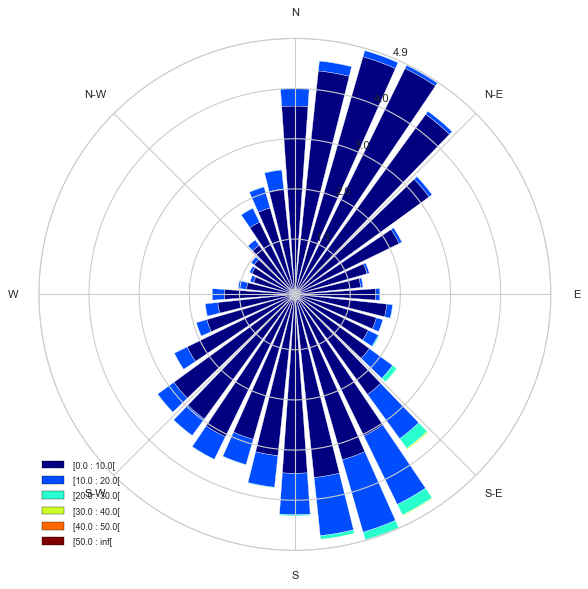

In [18]:
df.dir_windrose = df.dir
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

# 3. Modelling

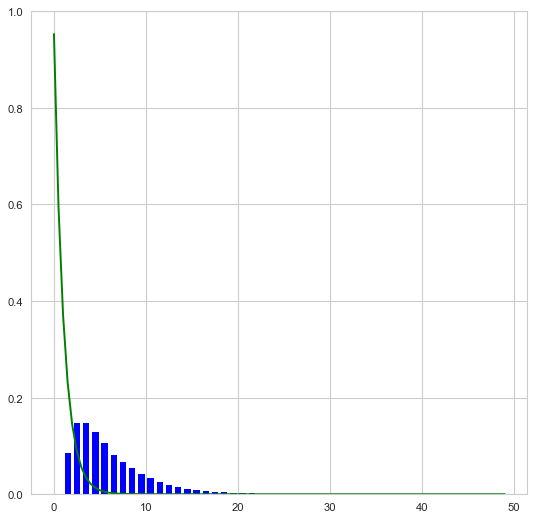

In [19]:
ax = WindAxes.from_ax()
ax, weibull_params = ax.pdf(df.speed, bins = arange(0, df.speed.max()))

In [20]:
def fit_weibull(df_speed):
    max_speed = df_speed.max()
    x = linspace(0, max_speed)
    data_size = len(df_speed)
    
    df_speed.hist(bins=arange(0, max_speed), alpha=0.5, label='Data', normed=True)  

    weibull_params = sp.stats.exponweib.fit(df_speed, floc=0, f0=1)
    y_weibull = sp.stats.exponweib.pdf(x, *weibull_params)
    plot(x, y_weibull, '--', color='black',label='Weibull') 

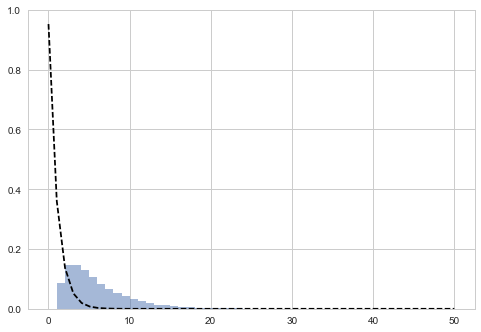

In [21]:
fit_weibull(df['speed'])

In [22]:
# Need more elaboration
sample_times = sample_time.value_counts()[sample_time.value_counts() > 2000]
sample_times = sample_times.index.tolist()
temp_df = df.query("sample_time in @sample_times")

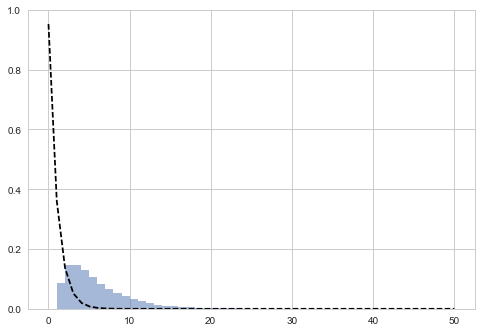

In [23]:
fit_weibull(temp_df['speed'])

In [24]:
sss

NameError: name 'sss' is not defined

In [ ]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

x = np.linspace(min(sample), max(sample))
w_scale = weibull_params[1]
c_shape = weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-')
plt.show()

In [ ]:
df['dir'] = 90-df.dir
df['dir'] = df['dir'].apply(lambda x: x + 360 if x < 0 else x)
alpha = 0
df['phi'] = df['dir'] - alpha
df['u'] = df['speed'] * np.cos(df['phi'] * pi / 180.0)
df['v'] = df['speed'] * np.sin(df['phi'] * pi / 180.0)
df.x=df.u
df.y=df.v
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_aspect('equal')
_ = df.plot(kind='scatter', x='u', y='v', alpha=0.35, ax=ax)
print(np.mean(df.u), np.mean(df.v))

In [ ]:
df['dir'].value_counts().sort_index()

In [ ]:
def cor_of_alpha(alpha):
    df['phi'] = df['dir'] - alpha
    df['u'] = df['speed'] * np.cos(df['phi'] * pi / 180.0)
    df['v'] = df['speed'] * np.sin(df['phi'] * pi / 180.0)
    cor = sp.stats.pearsonr(df['u'],df['v'])
    return cor[0]

# Try plot alpha - cor
import pylab 
# def plot_cor():
#     cors = []
#     for alpha in np.arange(0,180,10):
#         cor = cor_of_alpha(alpha)
#         std_u = np.std(df.u)
#         std_v = np.std(df.v)
#         comb = [alpha, cor, std_u, std_v]
#         cors.append(comb)
#         print comb

#     plt.scatter(zip(*cors)[0], zip(*cors)[1])

#     pylab.plot(zip(*cors)[0], zip(*cors)[2])
#     pylab.plot(zip(*cors)[0], zip(*cors)[3])
#     pylab.show()

In [ ]:
# Find the desired alpha for cor
alpha = sp.optimize.brentq(cor_of_alpha, 0, 90)
df['phi'] = df['dir'] - alpha
df['u'] = df['speed'] * np.cos(df['phi'] * pi / 180.0)
df['v'] = df['speed'] * np.sin(df['phi'] * pi / 180.0)
cor = sp.stats.pearsonr(df.u,df.v)
print(alpha, cor)

In [ ]:
# Compare u,v with normal distrubution
## P-P plot, vs Q-Q plot, should be q-q
import pylab 
import scipy.stats as stats

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
mean = np.mean(df.u)
std = np.std(df.u)
df['u_norm']=df['u'].apply(lambda x: (x-mean)/std)

mean = np.mean(df.v)
std = np.std(df.v)
df['v_norm']=df['v'].apply(lambda x: (x-mean)/std)
stats.probplot(df.u_norm, dist="norm", plot=pylab)
stats.probplot(df.v_norm, dist="norm", plot=pylab)

pylab.show()
u, sigu  = np.mean(df.u),np.std(df.u)
v, sigv = np.mean(df.v),np.std(df.v)
print(u, sigu)
print(v, sigv)
print(alpha)

In [ ]:
from scipy import integrate
from __future__ import division
from math import *
U = sqrt((u)**2 + (v)**2)
phi = atan(u/v)

def f(V,theta):
    return exp(-1/2* (( (V*cos(theta)-U*cos(phi)) /sigu)**2 + ((V*sin(theta)-U*sin(phi)) /sigv)**2))/(2*np.pi*sigu*sigv)*V
# integrate.nquad(f, [[0, inf],[0, 2*np.pi]])

In [ ]:
# x is the speed, y is the probalility
x_vals = np.linspace(0,30.)
y_vals =[integrate.nquad(f, [[0, x_val],[0, 2*np.pi]]) for x_val in x_vals]

In [ ]:
import numpy as np
import statsmodels.api as sm # recommended import according to the docs
import matplotlib.pyplot as plt

sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

x = np.linspace(min(sample), max(sample))
w_scale = weibull_params[1]
c_shape = weibull_params[3]

qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-')

x, y_ = x_vals, y_vals
y = array(list(zip(*y_))[0])
plt.plot(np.log(x), np.log(-np.log(1-y)),'-')

plt.show()